# Análisis de Datos para Detección de Fraudes

# Index 
1. [Packages](#packages)
2. [Análisis exploratorio y preprocesamiento](#análisis-de-datos-para-detección-de-fraudes)
   2.1. [Preprocesamieto](#preprocesamieto)
3. [PCA para detección de anomalías](#pca-para-detección-de-anomalías)
4. [Feature engineering y selección](#feature-engineering-y-selección)



Matriz de correlación: Con variables categóricas, una matriz de correlación tradicional (Pearson) no es adecuada. Necesitamos usar métodos específicos para variables mixtas.

PCA y Random Forest: Sí son compatibles, pero PCA se aplica típicamente a variables numéricas estandarizadas. Para variables categóricas, necesitamos preprocesamiento adecuado.

# Packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from scipy.stats import pointbiserialr, chi2_contingency


import sys
import os
from pathlib import Path
sys.path.append(os.path.abspath(".."))
from mlparadetectarfraudes.data import data

# Configuración de visualización
plt.style.use('ggplot')
sns.set_palette("Set2")

# Análisis exploratorio y preprocesamiento

Distribución de fraudes:
is_fraud
0    48243
1     1757
Name: count, dtype: int64
Porcentaje de fraudes: 3.51%


c:\Users\agust\miniconda3\envs\mlparadetectarfraudes\Lib\site-packages\scipy\stats\_stats_py.py:5534: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


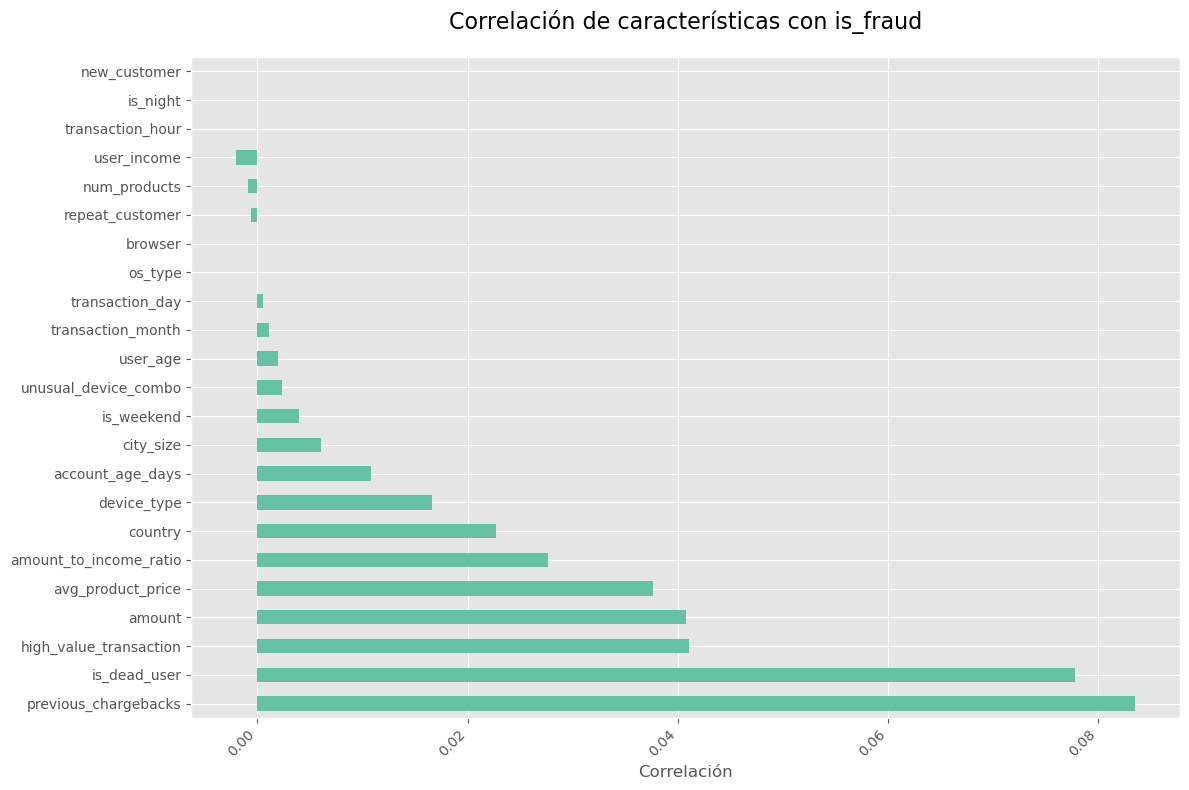

In [19]:
# Cargar tus datos (ya los tienes generados)
df = data.copy()

figures_path = Path('../reports/figures/')
figures_path.mkdir(parents=True, exist_ok=True)

# Ver distribución de la variable objetivo
print("Distribución de fraudes:")
print(df['is_fraud'].value_counts())
print(f"Porcentaje de fraudes: {df['is_fraud'].mean()*100:.2f}%")

from mlparadetectarfraudes.visualization import calculate_correlations

# Calcular y visualizar correlaciones
correlations = calculate_correlations(df)
plt.figure(figsize=(12, 8))
correlations.plot(kind='barh')
plt.title('Correlación de características con is_fraud', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Correlación')
plt.tight_layout()
plt.savefig(figures_path / 'correlation.png', dpi=300, bbox_inches='tight')
plt.show()

## Preprocesamieto

In [7]:
# Separar características y objetivo
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Identificar tipos de columnas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Pipelines de preprocesamiento
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Aplicar preprocesamiento
X_processed = preprocessor.fit_transform(X)

# Obtener nombres de características después del one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']['onehot']
feature_names = numerical_cols + cat_encoder.get_feature_names_out(categorical_cols).tolist()

X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# PCA para detección de anomalías

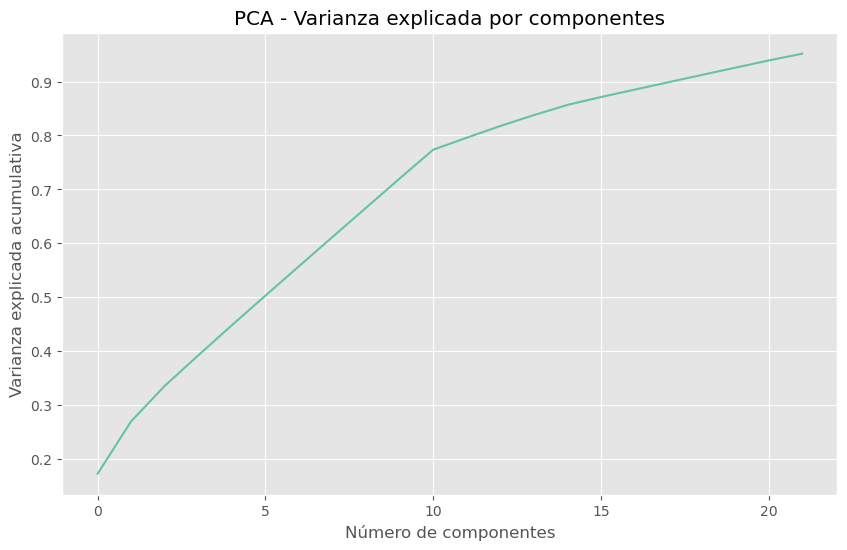

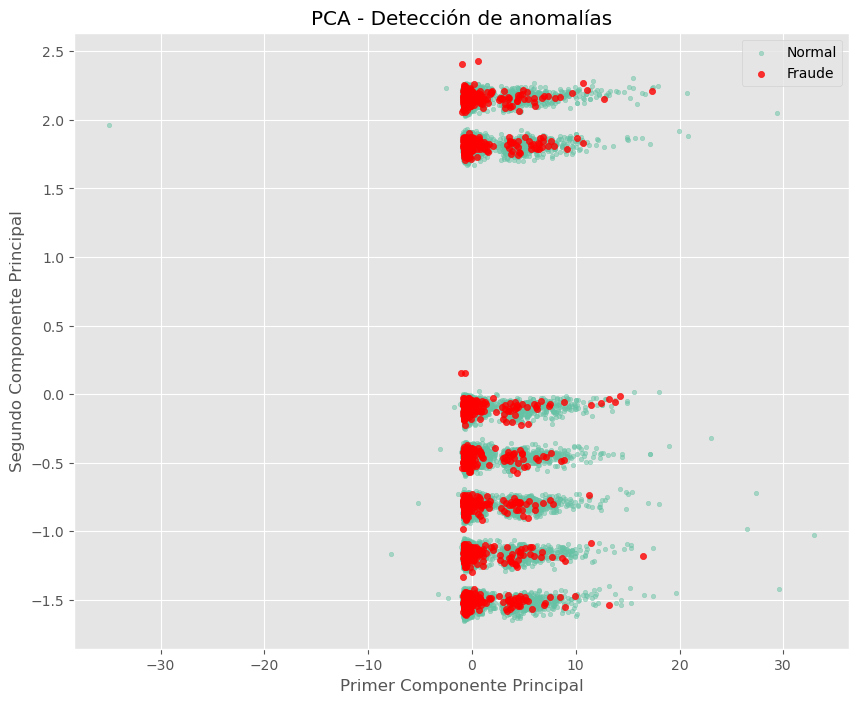

In [ ]:
# Aplicar PCA
pca = PCA(n_components=0.95)  # Mantener el 95% de varianza
X_pca = pca.fit_transform(X_processed_df)

# Visualizar varianza explicada
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulativa')
plt.title('PCA - Varianza explicada por componentes')
plt.grid(True)
plt.show()

# Crear DataFrame con componentes principales y variable objetivo
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['is_fraud'] = y.values

# Visualizar primeros dos componentes coloreados por fraude
plt.figure(figsize=(10, 8))
fraud_data = pca_df[pca_df['is_fraud'] == 1]
normal_data = pca_df[pca_df['is_fraud'] == 0]
plt.scatter(normal_data['PC1'], normal_data['PC2'], alpha=0.5, label='Normal', s=10)
plt.scatter(fraud_data['PC1'], fraud_data['PC2'], alpha=0.8, label='Fraude', s=20, color='red')
plt.xlabel('Primer Componente Principal (Explica {:.2f}% de varianza)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda Componente Principal (Explica {:.2f}% de varianza)'.format(pca.explained_variance_ratio_[1]*100))
plt.title('PCA - Visualización de Transacciones Normales y Fraudulentas')
plt.legend()
plt.show()

print("Interpretación:")
print("- Si los puntos rojos (fraudes) están agrupados en áreas específicas, indica que el PCA puede ayudar a detectar patrones de fraude")
print("- Si están dispersos por todo el gráfico, significa que los fraudes no siguen un patrón claro en las dos primeras componentes")
print("- Los outliers (puntos alejados del grupo principal) podrían representar transacciones anómalas")

Número de componentes para 95% de varianza: 22
Varianza explicada acumulada: 0.9516


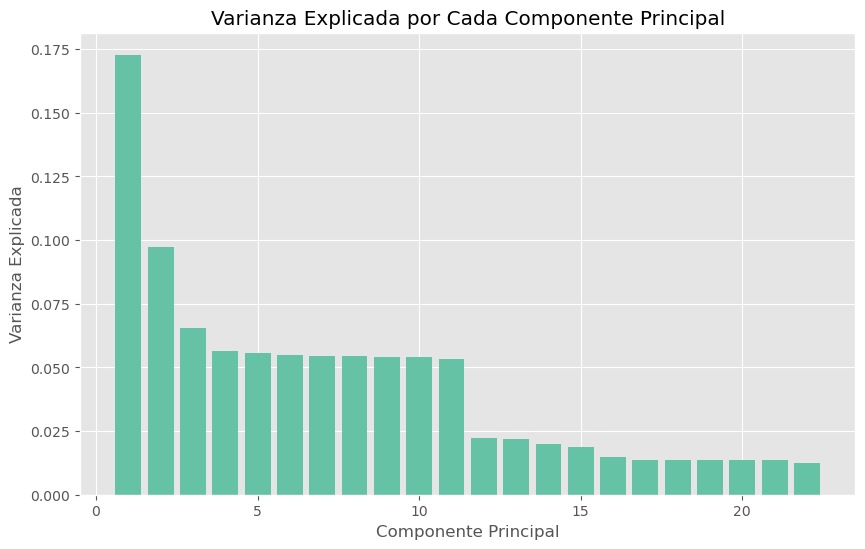

In [10]:
# Usar PCA con el número de componentes que explican el 95% de varianza
pca_95 = PCA(n_components=0.95)
X_pca_95 = pca_95.fit_transform(X_processed_df)

print(f"Número de componentes para 95% de varianza: {pca_95.n_components_}")
print(f"Varianza explicada acumulada: {np.sum(pca_95.explained_variance_ratio_):.4f}")

# Visualizar varianza explicada por componente
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca_95.explained_variance_ratio_)+1), pca_95.explained_variance_ratio_)
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Cada Componente Principal')
plt.show()

# Feature engineering y selección

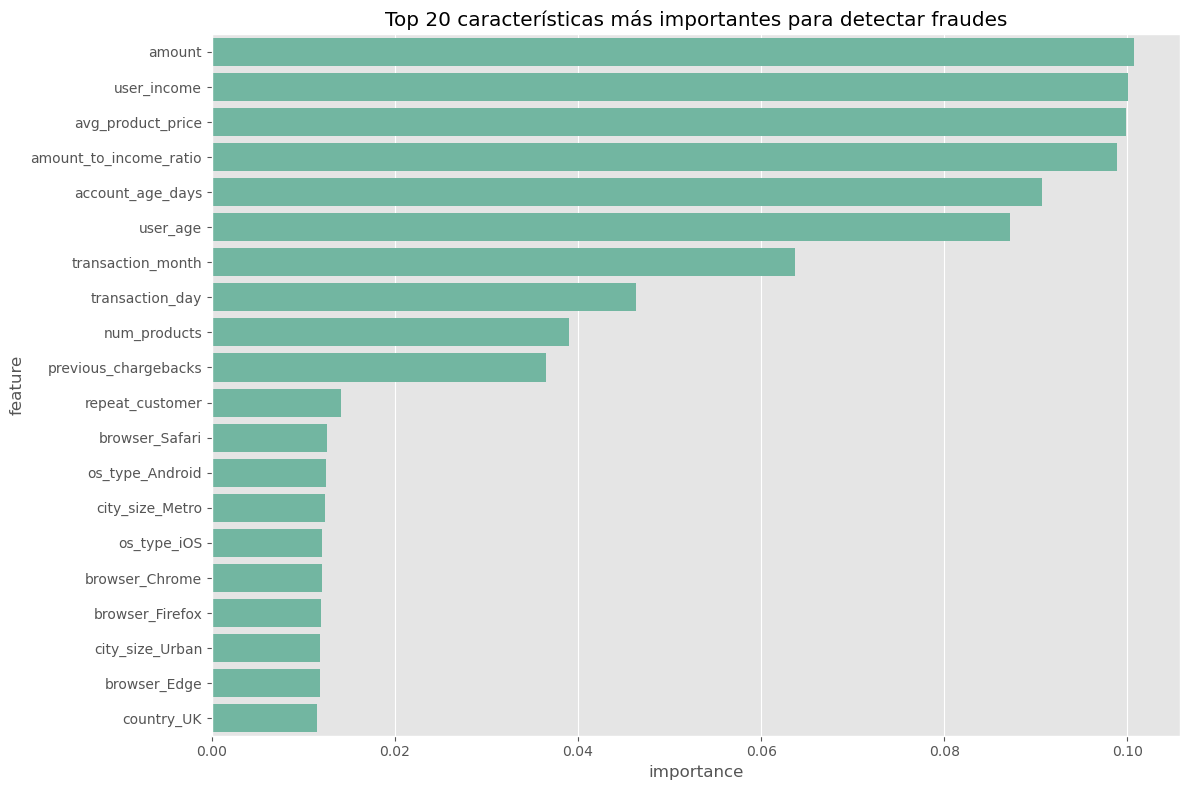

c:\Users\agust\miniconda3\envs\mlparadetectarfraudes\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\agust\miniconda3\envs\mlparadetectarfraudes\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Características seleccionadas: 19 de 38


In [11]:
# Dividir datos para modelado
X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y, test_size=0.3, random_state=42, stratify=y
)

# Entrenar Random Forest para importancia de características
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced'  # Importante para datos desbalanceados
)
rf.fit(X_train, y_train)

# Obtener importancia de características
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Visualizar importancia de características
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 características más importantes para detectar fraudes')
plt.tight_layout()
plt.show()

# Seleccionar características más importantes
selector = SelectFromModel(rf, prefit=True, threshold='median')
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Obtener nombres de características seleccionadas
selected_features = [feature_names[i] for i in selector.get_support(indices=True)]
print(f"Características seleccionadas: {len(selected_features)} de {len(feature_names)}")

# Modelado con Random Forest

Random Forest - Rendimiento:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     14473
           1       0.00      0.00      0.00       527

    accuracy                           0.96     15000
   macro avg       0.48      0.50      0.49     15000
weighted avg       0.93      0.96      0.95     15000

ROC AUC: 0.5535


c:\Users\agust\miniconda3\envs\mlparadetectarfraudes\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\agust\miniconda3\envs\mlparadetectarfraudes\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\agust\miniconda3\envs\mlparadetectarfraudes\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

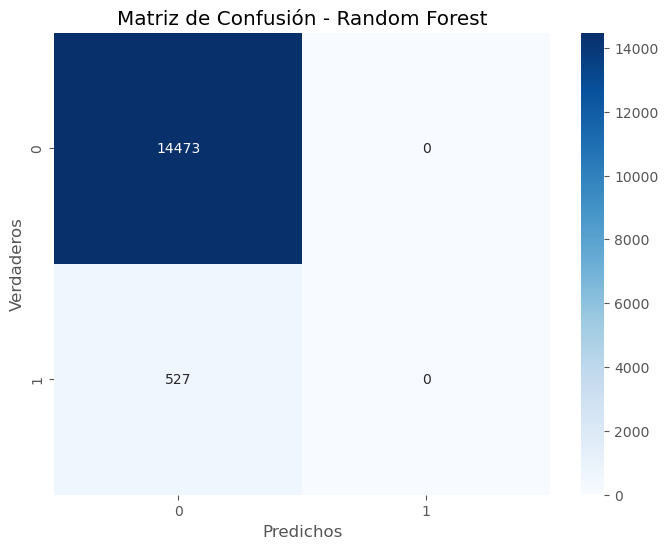

In [12]:
# Entrenar Random Forest con características seleccionadas
rf_selected = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)
rf_selected.fit(X_train_selected, y_train)

# Predecir y evaluar
y_pred = rf_selected.predict(X_test_selected)
y_pred_proba = rf_selected.predict_proba(X_test_selected)[:, 1]

print("Random Forest - Rendimiento:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

Distribución después de SMOTE:
is_fraud
0    33770
1    33770
Name: count, dtype: int64
Random Forest Balanceado - Rendimiento:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14473
           1       0.12      0.02      0.03       527

    accuracy                           0.96     15000
   macro avg       0.54      0.51      0.50     15000
weighted avg       0.94      0.96      0.95     15000

ROC AUC: 0.5801


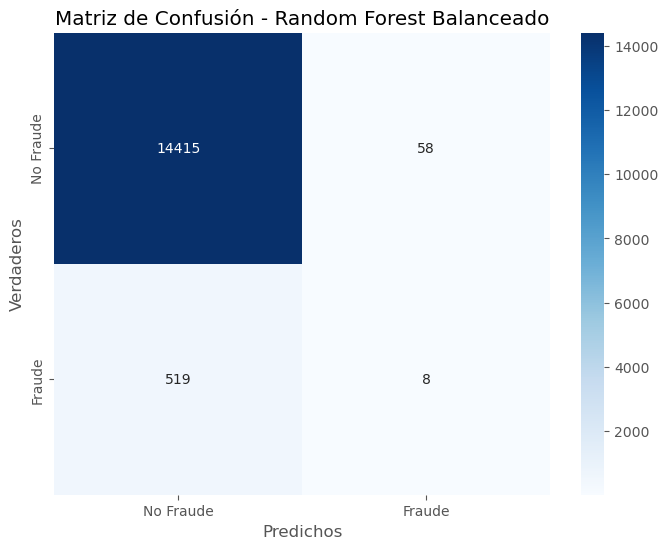

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Opción 1: Usar SMOTE para oversampling de la clase minoritaria
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Distribución después de SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Opción 2: Combinar oversampling y undersampling
resampling_pipeline = ImbPipeline([
    ('oversample', SMOTE(sampling_strategy=0.1, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5, random_state=42))
])

X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train, y_train)

# Entrenar Random Forest con datos balanceados
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Esto da más peso a la clase minoritaria
)
rf_balanced.fit(X_resampled, y_resampled)

# Predecir y evaluar
y_pred_balanced = rf_balanced.predict(X_test)
y_pred_proba_balanced = rf_balanced.predict_proba(X_test)[:, 1]

print("Random Forest Balanceado - Rendimiento:")
print(classification_report(y_test, y_pred_balanced))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_balanced):.4f}")

# Matriz de confusión para Random Forest balanceado
cm_rf_balanced = confusion_matrix(y_test, y_pred_balanced)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_balanced, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'])
plt.title('Matriz de Confusión - Random Forest Balanceado')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

# Modelado con XGBoost y comparación

XGBoost - Rendimiento:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     14473
           1       0.05      0.23      0.09       527

    accuracy                           0.83     15000
   macro avg       0.51      0.54      0.50     15000
weighted avg       0.94      0.83      0.88     15000

ROC AUC: 0.5600


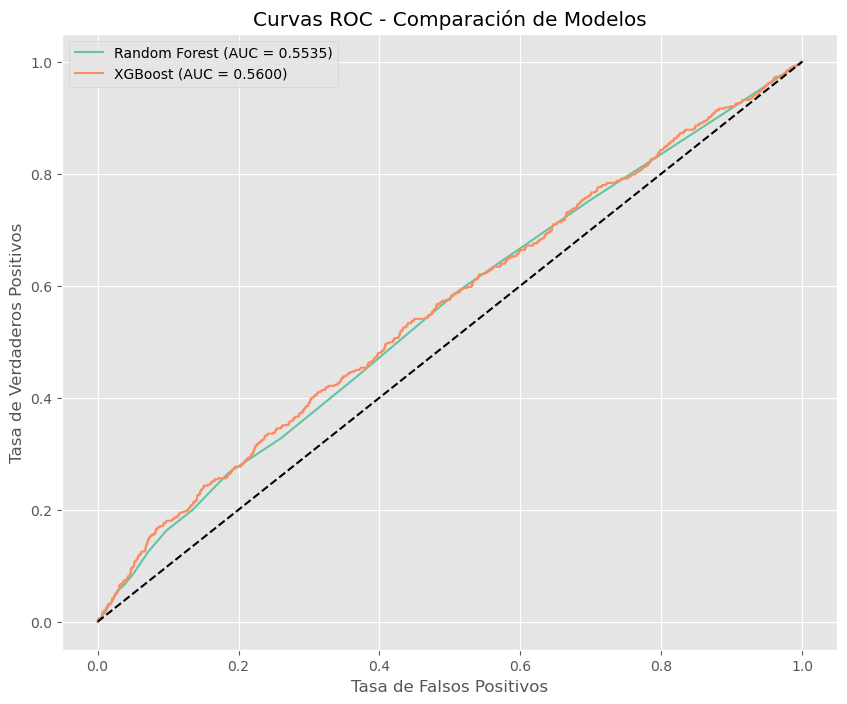

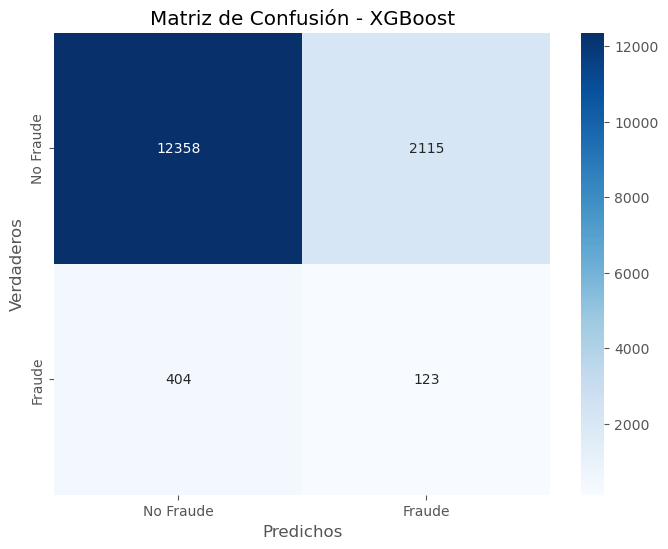

In [ ]:
# Entrenar XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=np.sum(y == 0) / np.sum(y == 1)  # Balancear clases
)
xgb_model.fit(X_train_selected, y_train)

# Predecir y evaluar
y_pred_xgb = xgb_model.predict(X_test_selected)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_selected)[:, 1]

print("XGBoost - Rendimiento:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")


# Matriz de confusión para XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'])
plt.title('Matriz de Confusión - XGBoost')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()
